  # PDAML: Geant4 Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import datasets, tree, metrics, model_selection, ensemble, neural_network
import census_utils
import dt_utils
from IPython.display import Image


# Step1: Geant Simulation

Using Geant4 a detector was constructed consisting of two structures. The first being 5 layers of 2 cm thick concrete followed by 5 layers of lead and liquid argon as used in checkpoint 2. These layers were labelled 1-5 for the 5 layers of liquid argon and 6-10 for the 5 layers of the concrete each 2cm thick. The concrete and liquid argon layers were sensitive and collected data on the energy deposited.

Concrete was chosen as a material for the first layer because it is not too absorbing and will therefore only stop low energy particles. Also it was placed 50 cm away from the liquid argon structure. The reason for that was to avoid excessive particles backward scattering from liquid argon back to the concrete structure. The concrete structure was also a smaller radius than the liquid argon. The reason for that was to ensure that the majority of the particles that scatter in the concrete structure reach the liquid argon structure and deposit energy there as well.

The simulation was then ran for both electrons and protons ranging from energies 200MeV to 25.15 GeV. This was done in steps of 50MeV. The simulation took roughly a minute for both types of particles. The produced data was a .csv file containing the amount of energy deposited in each of the 10 layers of the detector as well as the true energy of the particle that was fired into the detector.

# Step 2 - Data reconstruction

With the outputted .csv files we can now look at how well the data collected by our detector matches the true data of the incident particles. For each the proton and electron data a column was also created with the name of the particle which will be used later in the machine learning step.

First of all the energy measured by the detector was calibrated to the true energy. The callibrated energy was then also added to the data frame for both the electron and proton.

In [2]:
electron_data = pd.read_csv( "output_electron_Energy.csv", comment="#", header = None)
proton_data   = pd.read_csv( "output_proton_Energy.csv", comment="#", header = None)

electron_data['Particle'] = 'Electron'
proton_data['Particle'] = 'Proton'

In [3]:
electron_data.head()

,0,1,2,3,4,5,6,7,8,9,10,Particle
0,200,39.1730,8.6038,0.00000,0.00000,0.00000,18.7630,16.1557,16.7944,23.2157,23.8686,Electron
1,250,17.6554,17.7767,0.00000,0.00000,0.00000,14.0080,19.4755,52.7623,30.0894,42.0870,Electron
2,300,49.9430,9.9341,1.98727,0.00000,0.00000,14.5329,23.2787,22.1386,28.0072,51.7596,Electron
3,350,108.4990,13.5093,3.95544,0.00000,1.71393,24.4730,33.8399,44.6694,29.3693,18.2912,Electron
4,400,129.1500,68.6969,16.14390,1.95013,0.00000,13.3053,20.9222,18.8996,17.1350,30.4006,Electron


In [4]:
#sum over 10 regions
e_measured = electron_data.iloc[:,1:].sum(axis = 1)
e_true = electron_data[0]

#Calculate calibrated energy
calib = e_true.mean()/e_measured.mean()

In [5]:
#Calculating the calibrated energy and adding that to the DF
e_calibrated = e_measured * calib
electron_data['Calibrated energy measured'] = e_calibrated
electron_data

,0,1,2,3,4,5,6,7,8,9,10,Particle,Calibrated energy measured
0,200,39.1730,8.6038,0.000000,0.000000,0.000000,18.7630,16.1557,16.7944,23.21570,23.8686,Electron,238.458683
1,250,17.6554,17.7767,0.000000,0.000000,0.000000,14.0080,19.4755,52.7623,30.08940,42.0870,Electron,315.377748
2,300,49.9430,9.9341,1.987270,0.000000,0.000000,14.5329,23.2787,22.1386,28.00720,51.7596,Electron,327.948766
3,350,108.4990,13.5093,3.955440,0.000000,1.713930,24.4730,33.8399,44.6694,29.36930,18.2912,Electron,452.794099
4,400,129.1500,68.6969,16.143900,1.950130,0.000000,13.3053,20.9222,18.8996,17.13500,30.4006,Electron,515.076219
5,450,70.6015,56.3409,0.915813,1.028570,0.000000,15.5794,14.9877,26.2872,47.72620,49.4766,Electron,460.315839
6,500,96.9232,16.7144,5.067750,3.302230,1.037480,25.8157,53.2445,42.2901,20.63750,22.0044,Electron,466.975273
7,550,86.2925,35.3907,25.650600,9.204770,1.353660,15.8104,17.7191,16.0636,30.51340,33.4773,Electron,441.659014
8,600,155.9780,49.0124,25.805800,7.144210,0.000000,16.1699,18.0643,29.6192,47.73100,54.5082,Electron,657.313358
9,650,67.7342,44.9997,27.640500,7.154690,0.000000,16.3854,33.8226,73.4928,104.20500,121.5260,Electron,808.495898


Notice that the calibratedenergy measured for the electron in the first 18 energies.

In [6]:
#sum over 10 regions
p_measured = proton_data.iloc[:,1:].sum(axis = 1)
p_true = proton_data[0]

#Calculate calibrated energy
calib = p_true.mean()/p_measured.mean()

In [7]:
#Calculating the calibrated energy and adding that to the DF
p_calibrated = p_measured * calib
proton_data['Calibrated energy measured'] = p_calibrated
proton_data

,0,1,2,3,4,5,6,7,8,9,10,Particle,Calibrated energy measured
0,200,0.00000,0.000000,0.000000,0.000000,0.000000,37.7353,45.3957,65.3657,51.503400,0.000000,Proton,750.958676
1,250,0.00000,0.000000,0.000000,0.000000,0.000000,32.7291,37.3123,38.9709,51.795900,89.191700,Proton,938.697500
2,300,90.96230,0.000000,0.000000,0.000000,0.000000,28.4725,29.2371,33.0003,36.507500,42.347700,Proton,978.226067
3,350,142.93800,0.000000,0.000000,0.000000,0.000000,25.6514,27.0229,29.1744,28.768100,32.268800,Proton,1073.208024
4,400,4.08446,2.747340,0.065267,0.000000,0.000000,26.5296,25.9125,25.8028,27.320700,28.627000,Proton,529.762282
5,450,77.56720,102.489000,62.410200,0.000000,0.000000,21.8529,22.3114,23.7883,24.439100,24.737800,Proton,1350.207629
6,500,292.40200,0.329345,0.000000,0.000000,0.000000,22.9400,23.2175,23.9613,21.675700,23.420900,Proton,1531.754971
7,550,0.00000,0.131246,0.000000,0.000000,0.000000,21.1754,115.4990,25.1641,0.429721,0.234809,Proton,610.657797
8,600,90.16310,49.534200,0.566105,45.234300,0.196589,19.1186,21.7571,28.5771,31.642700,97.949100,Proton,1444.614329
9,650,53.62430,59.537700,68.272500,155.384000,7.737520,19.0105,20.0105,20.1469,20.795900,21.849700,Proton,1676.024480


Notice that the calibratedenergy measured for the electron in the first 25 energies.

The for the machine learning step the two data frames of electron and proton data were combined. Then, the target names, target values and data names and values were given. A search was preformed over the train-test data split to determine a good split value. Because of the way the data is presented with first 500 vales being electrons and second 500 being protons scikit-learns model_selection.train_test_split() was used in order to avoid introducing a bias.

The data was then used to form a decision tree. No grid serch over parameters such as max leaf nodes and max depth, because as seen in previous projects, the parameters set automatically preform well. However because there are no parameters placed on the decision tree is does grow as big as it needs to, and is therefore harder to read. A similar case as in the census project. In order to validate the decision tree the test data was used to find the accuracy and the confusion matrix. With the accuracy being calculated to be 0.886667.

In [8]:
frames = [electron_data, proton_data]
result = pd.concat(frames)
result.head()

,0,1,2,3,4,5,6,7,8,9,10,Particle,Calibrated energy measured
0,200,39.1730,8.6038,0.00000,0.00000,0.00000,18.7630,16.1557,16.7944,23.2157,23.8686,Electron,238.458683
1,250,17.6554,17.7767,0.00000,0.00000,0.00000,14.0080,19.4755,52.7623,30.0894,42.0870,Electron,315.377748
2,300,49.9430,9.9341,1.98727,0.00000,0.00000,14.5329,23.2787,22.1386,28.0072,51.7596,Electron,327.948766
3,350,108.4990,13.5093,3.95544,0.00000,1.71393,24.4730,33.8399,44.6694,29.3693,18.2912,Electron,452.794099
4,400,129.1500,68.6969,16.14390,1.95013,0.00000,13.3053,20.9222,18.8996,17.1350,30.4006,Electron,515.076219


In [9]:
data_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8', 'layer9', 'layer10']
target_names = ['Electron', 'Proton']
data_values = result[[1,2,3,4,5,6,7,8,9,10]]
target_values = result['Particle']

NN parameters
{'max_iter': 100}
Split sample:
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.2  0.3  0.4  0.5
 0.6  0.7  0.8  0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99]
Running with test size of: 0.01
Running with test size of: 0.02


/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Running with test size of: 0.03
Running with test size of: 0.04
Running with test size of: 0.05


/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Running with test size of: 0.06
Running with test size of: 0.07
Running with test size of: 0.08


/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Running with test size of: 0.09
Running with test size of: 0.10


/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Running with test size of: 0.20
Running with test size of: 0.30
Running with test size of: 0.40
Running with test size of: 0.50


/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Running with test size of: 0.60
Running with test size of: 0.70


/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Running with test size of: 0.80
Running with test size of: 0.90
Running with test size of: 0.91
Running with test size of: 0.92
Running with test size of: 0.93
Running with test size of: 0.94


/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Running with test size of: 0.95
Running with test size of: 0.96
Running with test size of: 0.97
Running with test size of: 0.98
Running with test size of: 0.99


/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


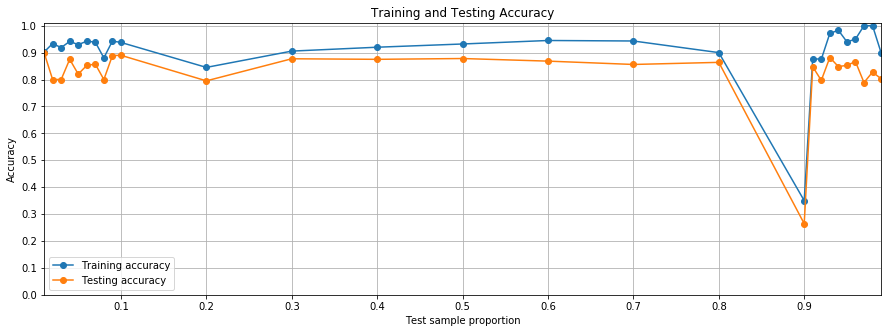

In [10]:
params = { 'max_iter' : 100 }
census_utils.compare_traintest(data_values, target_values, params=params)
plt.show() 

The result shows that anywhere between 0.1 and 0.9 of test sample gives good results. So in this case I decided to do a 0.7 train and 0.3 of test data.

In [11]:
#0.7 of data for train
train_data, test_data, train_target, test_target = model_selection.train_test_split(
    data_values, target_values, test_size=0.3, random_state=0)

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(700, 10) (700,) (300, 10) (300,)


In [12]:
clf = tree.DecisionTreeClassifier()
fit = clf.fit(train_data, train_target)
expected = test_target
predicted = clf.predict(test_data)

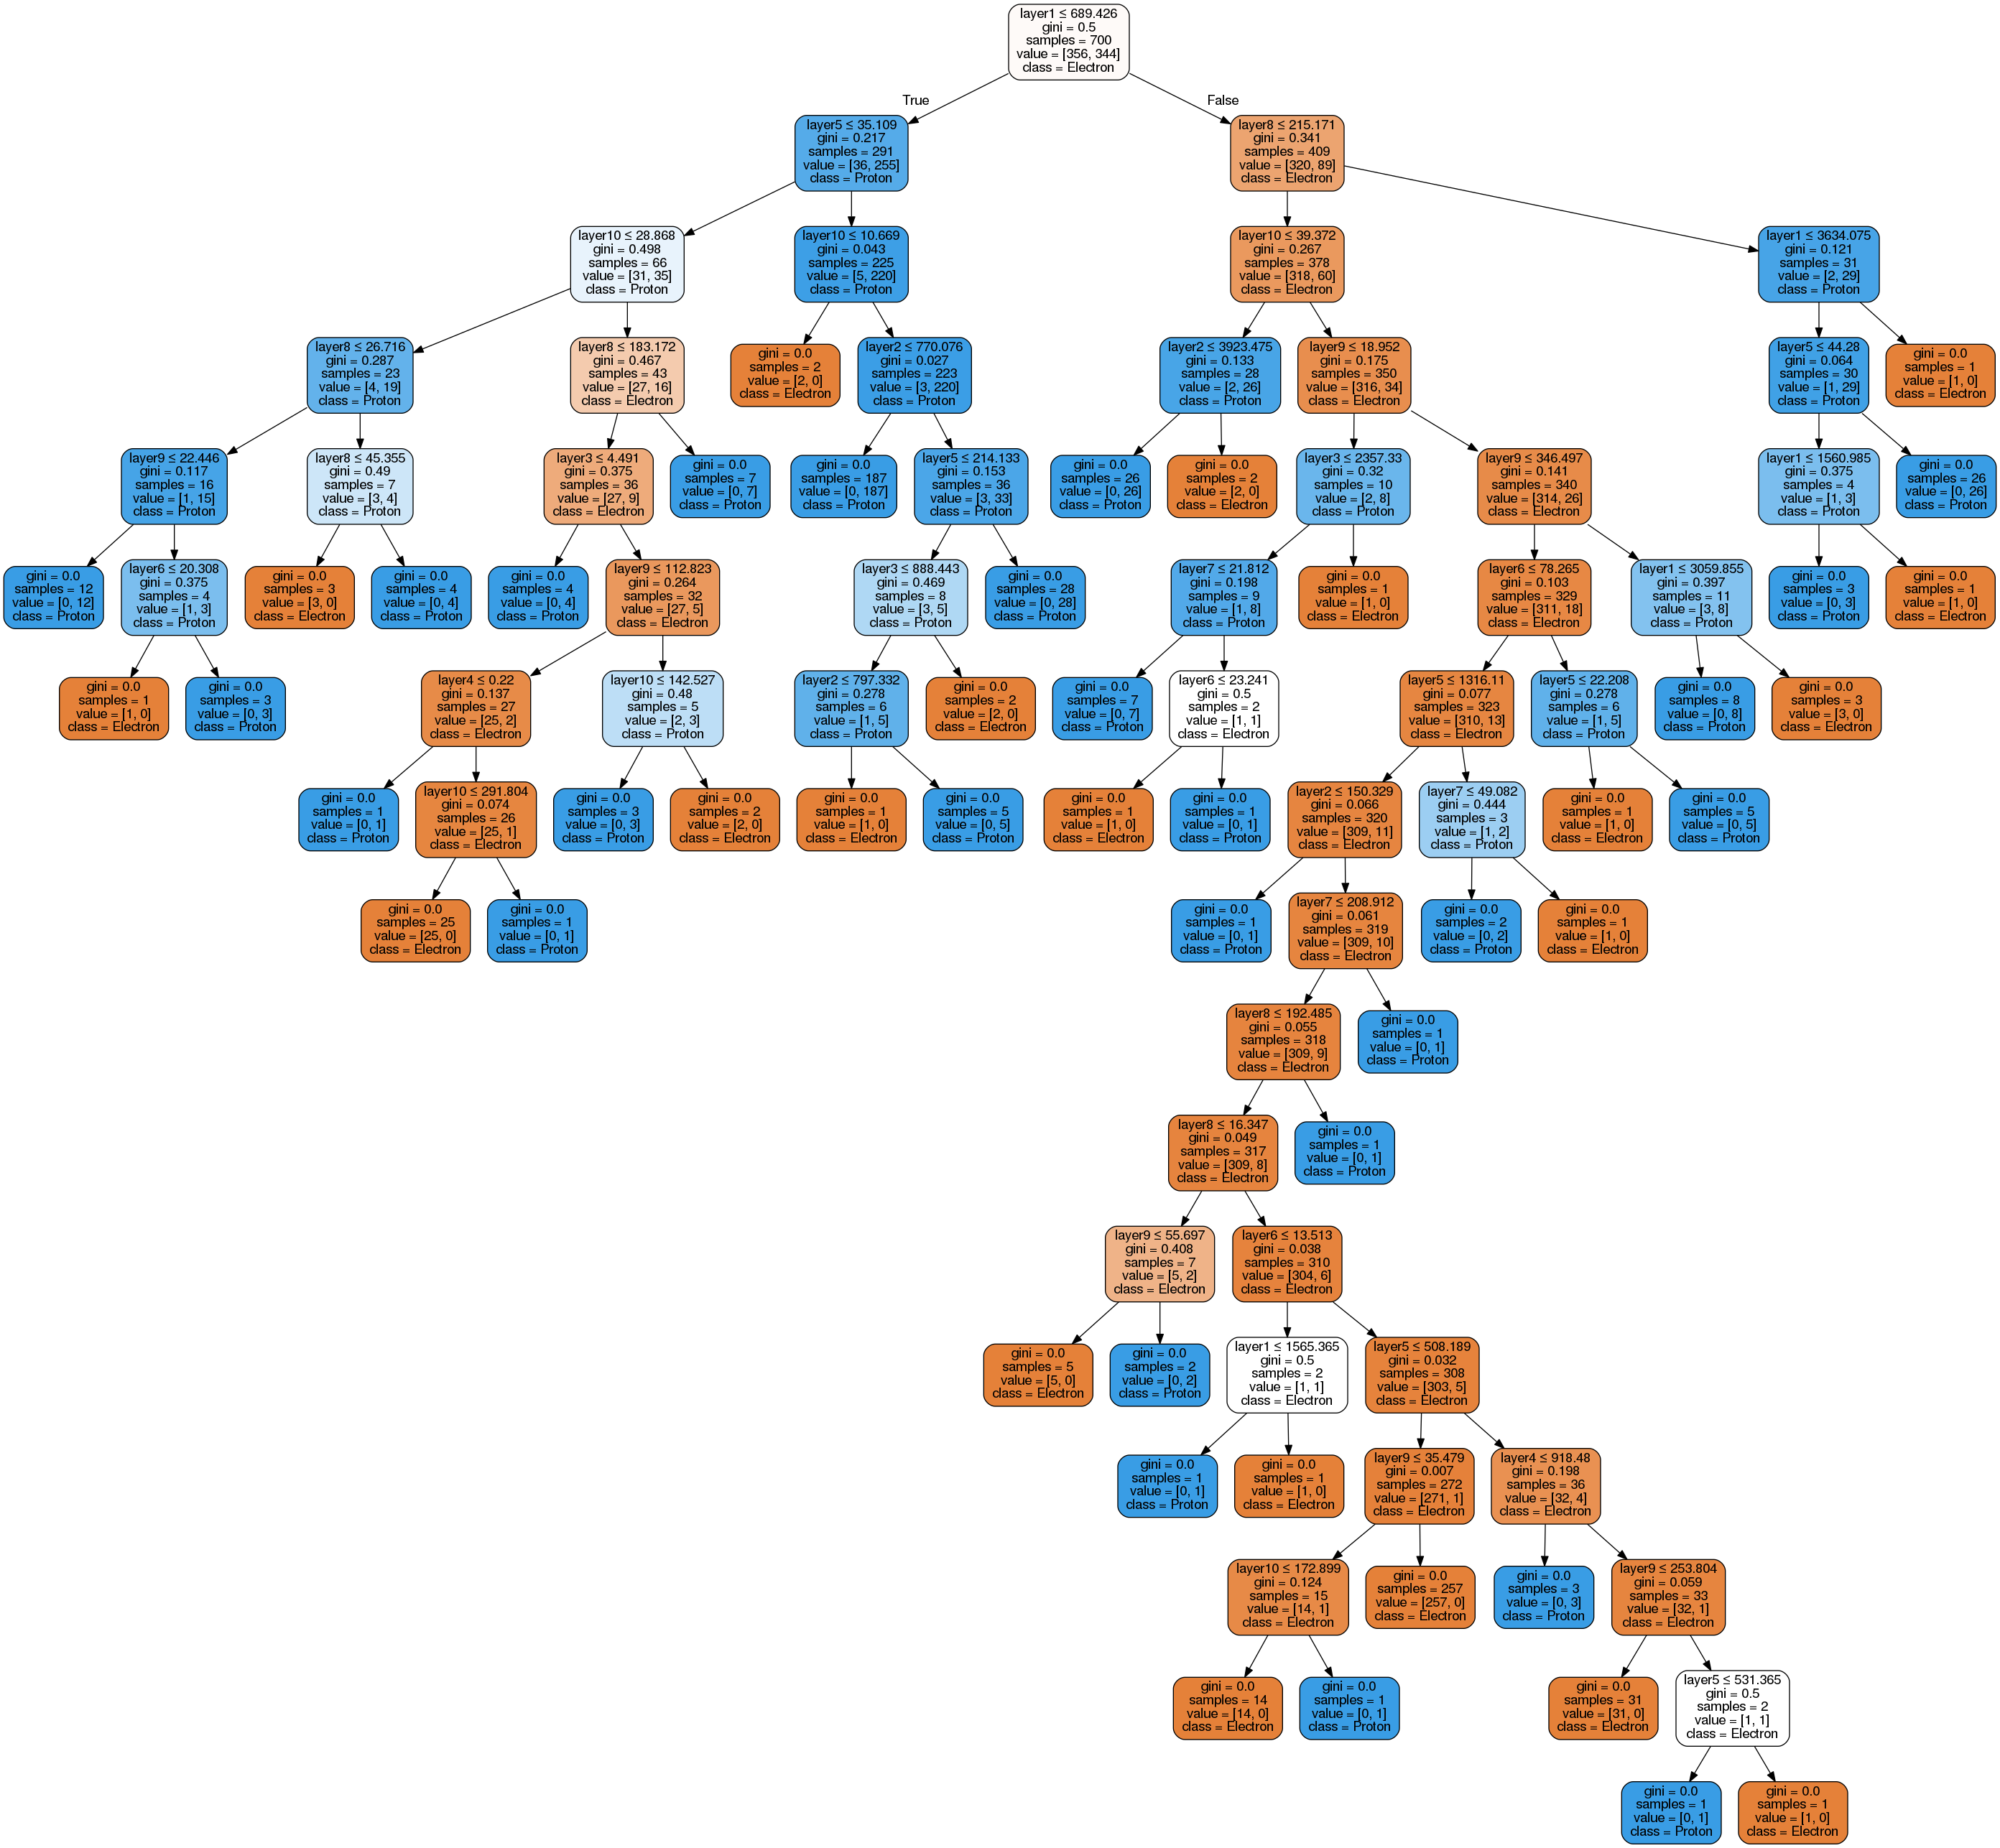

In [13]:
# plot decision tree 
graph = dt_utils.plotDT(fit, data_names, target_names)
Image(graph.create_png())

In [14]:
d = model_selection.train_test_split(data_values, target_values, test_size=0.3, random_state=0)
expected, predicted = dt_utils.runML(tree.DecisionTreeClassifier(), d)
report = metrics.classification_report(expected, predicted)
print(report)

              precision    recall  f1-score   support

    Electron       0.89      0.87      0.88       144
      Proton       0.88      0.90      0.89       156

   micro avg       0.88      0.88      0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



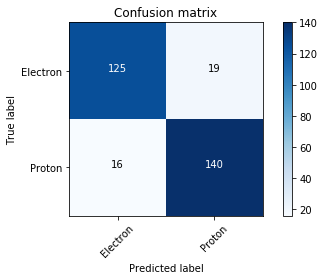

Accuracy: 0.8833333333333333


In [15]:
cm = metrics.confusion_matrix(expected, predicted)
dt_utils.plot_cm(cm, target_names)
plt.show()
acc = metrics.accuracy_score(expected, predicted)
print('Accuracy: '+str(acc))

# Step 3 - Data validation

 The histograms for (calibrated energy - true energy)/true energy were then plotted, as well as the 2D histograms of (calibrated energy - true energy)/true energy over the range of energies.

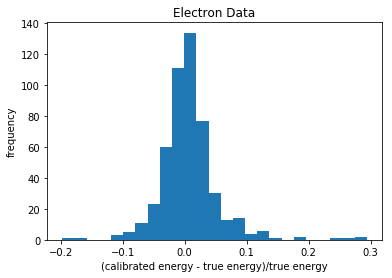

In [16]:
e_hist_values = (e_calibrated - e_true)/e_true
plt.title('Electron Data')
plt.xlabel('(calibrated energy - true energy)/true energy')
plt.ylabel('frequency')
plt.hist(e_hist_values, bins = 25)
plt.show()

In [17]:
np.std(e_hist_values)

0.047415575101853874

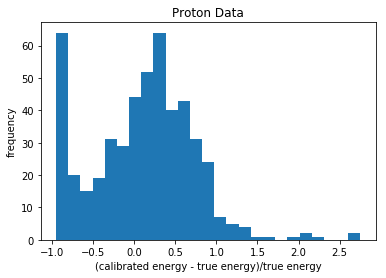

In [18]:
p_hist_values = (p_calibrated - p_true)/p_true
plt.title('Proton Data')
plt.xlabel('(calibrated energy - true energy)/true energy')
plt.ylabel('frequency')
plt.hist(p_hist_values, bins = 25)
plt.show()

In [19]:
np.std(p_hist_values)

0.627866993486234

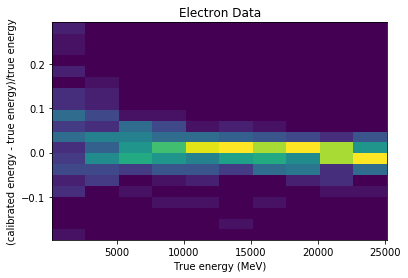

In [20]:
plt.hist2d( e_true , e_hist_values , bins =(10, 20) )
plt.title('Electron Data')
plt.ylabel('(calibrated energy - true energy)/true energy')
plt.xlabel('True energy (MeV)')
plt.show()

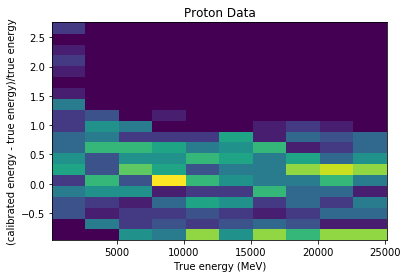

In [21]:
plt.hist2d( p_true , p_hist_values , bins =(10, 20) )
plt.title('Proton Data')
plt.ylabel('(calibrated energy - true energy)/true energy')
plt.xlabel('True energy (MeV)')
plt.show()

Overall we can see that the electron data is much better behaved than the proton data. With a standard deviation of 0.0474, while the proton data has a standard deviation of 0.6278. Also by looking at the two 2D graphs we can see that the electron data gets better at higher energies, meanwhile the proton data does improove at higher energies, however the improvement is not as great as for the electron.

The reason for electron detection being more accurate at higher energies must be because of at the lower energies the electron not being able to deposit large enough proportion of its energy in the liquid argon layers. Because of this the callibration is not as accurate. However at higher energies the electrons will be able to deposit most of their energies in the liquid argon layers.

The reason for poor proton detection must be due to the electron interacting with matter less than the proton. Because of this weaker interaction the electron is able to pass through the concrete layers without scattering too much, depositing too much energy or going off path too much. Therefore it is able to reach the liquid argon detector where it can deposit the rest of its energy. On the other hand the proton interacts with matter a lot more with the concrete part of the detector. Because of this strong interaction, a smaller fraction of the energy is deposited in the liquid argon layer. Due to this stronger interaction a proton will also scatter at greater angles and possibly miss the liquid argon detector alltogether. Missing the liquid argon detector is very bad for the callibration as a large proportion of the true proton energy will not be deposited. In the next section there are improvements made to the detector that improve the detectors performance for detecting proton energies.

# Step 4 - Improvement and discussion

In order to improve the result of distinguishing the electrons from the protons a neural network was implementes. From previous experience the learning rates for neural netowrks have to be a small as possible. Therefore a neural netowrk with a learning rate on 0.0001 with 500 hidden layers was set up. The same train-test data split was used as in the decision tree. However with the neural network the accuracy came out to be 0.901, which is margionally larger than that of the decision tree.

In [22]:
%%time
clf = neural_network.MLPClassifier()
fit = clf.fit(train_data, train_target)

CPU times: user 904 ms, sys: 3.95 ms, total: 908 ms
Wall time: 281 ms


In [23]:
#Form a neural network with 500 hidden layers and with a slowe learning rate 0.0001
clf = neural_network.MLPClassifier(verbose=True, hidden_layer_sizes = (500,), learning_rate_init = 0.0001)
fit = clf.fit(train_data, train_target)

Iteration 1, loss = 12.17481759
Iteration 2, loss = 12.95800988
Iteration 3, loss = 13.58547758
Iteration 4, loss = 13.05171545
Iteration 5, loss = 10.84533383
Iteration 6, loss = 7.75977828
Iteration 7, loss = 6.62489306
Iteration 8, loss = 6.08364414
Iteration 9, loss = 5.39156130
Iteration 10, loss = 4.71911995
Iteration 11, loss = 4.13523287
Iteration 12, loss = 3.69095601
Iteration 13, loss = 3.37089311
Iteration 14, loss = 3.35939742
Iteration 15, loss = 3.17283305
Iteration 16, loss = 2.89509318
Iteration 17, loss = 2.62984828
Iteration 18, loss = 2.41599938
Iteration 19, loss = 2.33445862
Iteration 20, loss = 2.28175648
Iteration 21, loss = 2.24187513
Iteration 22, loss = 2.17380810
Iteration 23, loss = 2.12316008
Iteration 24, loss = 2.05018952
Iteration 25, loss = 1.97166172
Iteration 26, loss = 1.88467716
Iteration 27, loss = 1.82164008
Iteration 28, loss = 1.74979148
Iteration 29, loss = 1.66984764
Iteration 30, loss = 1.59122658
Iteration 31, loss = 1.52593369
Iteration 32

/opt/conda-pdaml/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


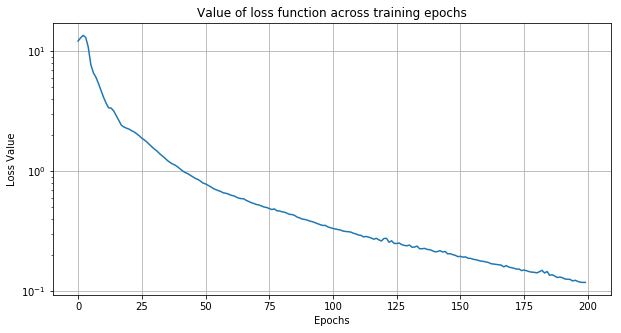

In [24]:
census_utils.lossplot(clf.loss_curve_, scale='log')
plt.show()

In [25]:
report = metrics.classification_report(expected, predicted)
print(report)

              precision    recall  f1-score   support

    Electron       0.89      0.87      0.88       144
      Proton       0.88      0.90      0.89       156

   micro avg       0.88      0.88      0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



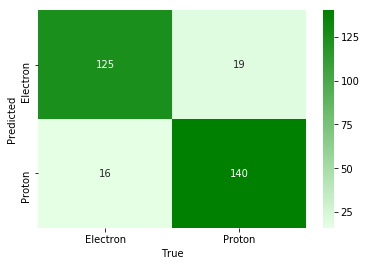

Accuracy: 0.8833333333333333


In [26]:
cm = metrics.confusion_matrix(expected, predicted)
census_utils.heatmap(cm, labels=['True', 'Predicted'], 
        classes=[target_names, target_names],
        normalize=False)
plt.show()
print('Accuracy: ' +str(clf.score(test_data, test_target)))

Second improvement was trying to make the detector better at detecting the protons. This was done by making the concrete part of the detector thicker (7.5 cm * 5 layers). This ensured that the protons deposit more energy is the concrete layers as well, before scattering and not depositing energy is the other part of the detector. However the problem with this being that the electron then struggles to deposit its energy in the detector at low energies. This can be seen in the 2D plot.

In [27]:
proton_data   = pd.read_csv( "1output_nt_Energy.csv", comment="#", header = None)

In [28]:
#sum over 10 regions
p_measured = proton_data.iloc[:,1:].sum(axis = 1)
p_true = proton_data[0]

#Calculate calibrated energy
calib = p_true.mean()/p_measured.mean()

In [29]:
#Calculating the calibrated energy and adding that to the DF
p_calibrated = p_measured * calib
proton_data['Calibrated energy measured'] = p_calibrated

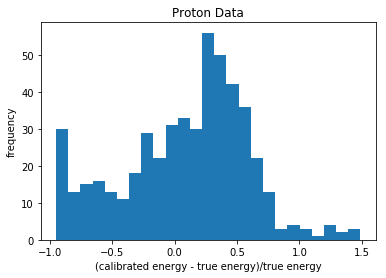

In [30]:
p_hist_values = (p_calibrated - p_true)/p_true
plt.title('Proton Data')
plt.xlabel('(calibrated energy - true energy)/true energy')
plt.ylabel('frequency')
plt.hist(p_hist_values, bins = 25)
plt.show()

In [31]:
np.std(p_hist_values)

0.507206915201911

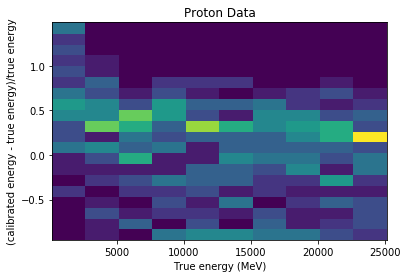

In [32]:
plt.hist2d( p_true , p_hist_values , bins =(10, 20) )
plt.title('Proton Data')
plt.ylabel('(calibrated energy - true energy)/true energy')
plt.xlabel('True energy (MeV)')
plt.show()

In [33]:
electron_data = pd.read_csv( "2output_nt_Energy.csv", comment="#", header = None)
#sum over 10 regions
e_measured = electron_data.iloc[:,1:].sum(axis = 1)
e_true = electron_data[0]

#Calculate calibrated energy
calib = e_true.mean()/e_measured.mean()
e_calibrated = e_measured * calib
electron_data['Calibrated energy measured'] = e_calibrated

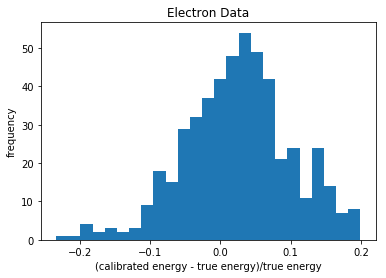

In [34]:
e_hist_values = (e_calibrated - e_true)/e_true
plt.title('Electron Data')
plt.xlabel('(calibrated energy - true energy)/true energy')
plt.ylabel('frequency')
plt.hist(e_hist_values, bins = 25)
plt.show()

In [35]:
np.std(e_hist_values)

0.07551387939325414

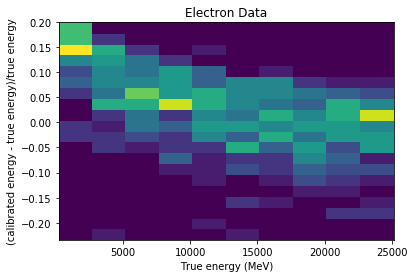

In [36]:
plt.hist2d( e_true , e_hist_values , bins =(10, 20) )
plt.title('Electron Data')
plt.ylabel('(calibrated energy - true energy)/true energy')
plt.xlabel('True energy (MeV)')
plt.show()

In the new detector for the electron data there can be seen a energy bias. At lower electron energies the electron is bad at depositing energies in the detector. Therefore the calibration overcorrects the low energy electrons making the (calibrated energy - true energy)/true energy slightly on the positinve side. However at higher energies that seems to go away.

In [37]:
frames = [electron_data, proton_data]
result = pd.concat(frames)
result.head()

,0,1,2,3,4,5,6,7,8,9,10,Calibrated energy measured
0,200,0.154157,0.00000,0.00000,0.00000,0.0,90.2937,76.3515,20.3903,11.92750,0.011438,239.811521
1,250,0.202920,14.11390,2.76456,0.00000,0.0,28.9791,25.3672,59.8681,34.08810,57.196300,268.054376
2,300,0.360863,6.44924,0.00000,0.00000,0.0,72.6681,106.5620,51.9634,8.56402,47.762200,354.462815
3,350,0.661329,14.46740,17.35460,4.22688,0.0,34.1978,85.5071,102.6910,27.08260,28.915200,379.481146
4,400,5.524260,0.00000,0.00000,0.00000,0.0,140.5110,199.2900,37.0732,10.26570,0.000000,472.887328


In [38]:
#0.7 of data for train
train_data, test_data, train_target, test_target = model_selection.train_test_split(
    data_values, target_values, test_size=0.3, random_state=0)

print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(700, 10) (700,) (300, 10) (300,)


In [39]:
clf = tree.DecisionTreeClassifier()
fit = clf.fit(train_data, train_target)
expected = test_target
predicted = clf.predict(test_data)

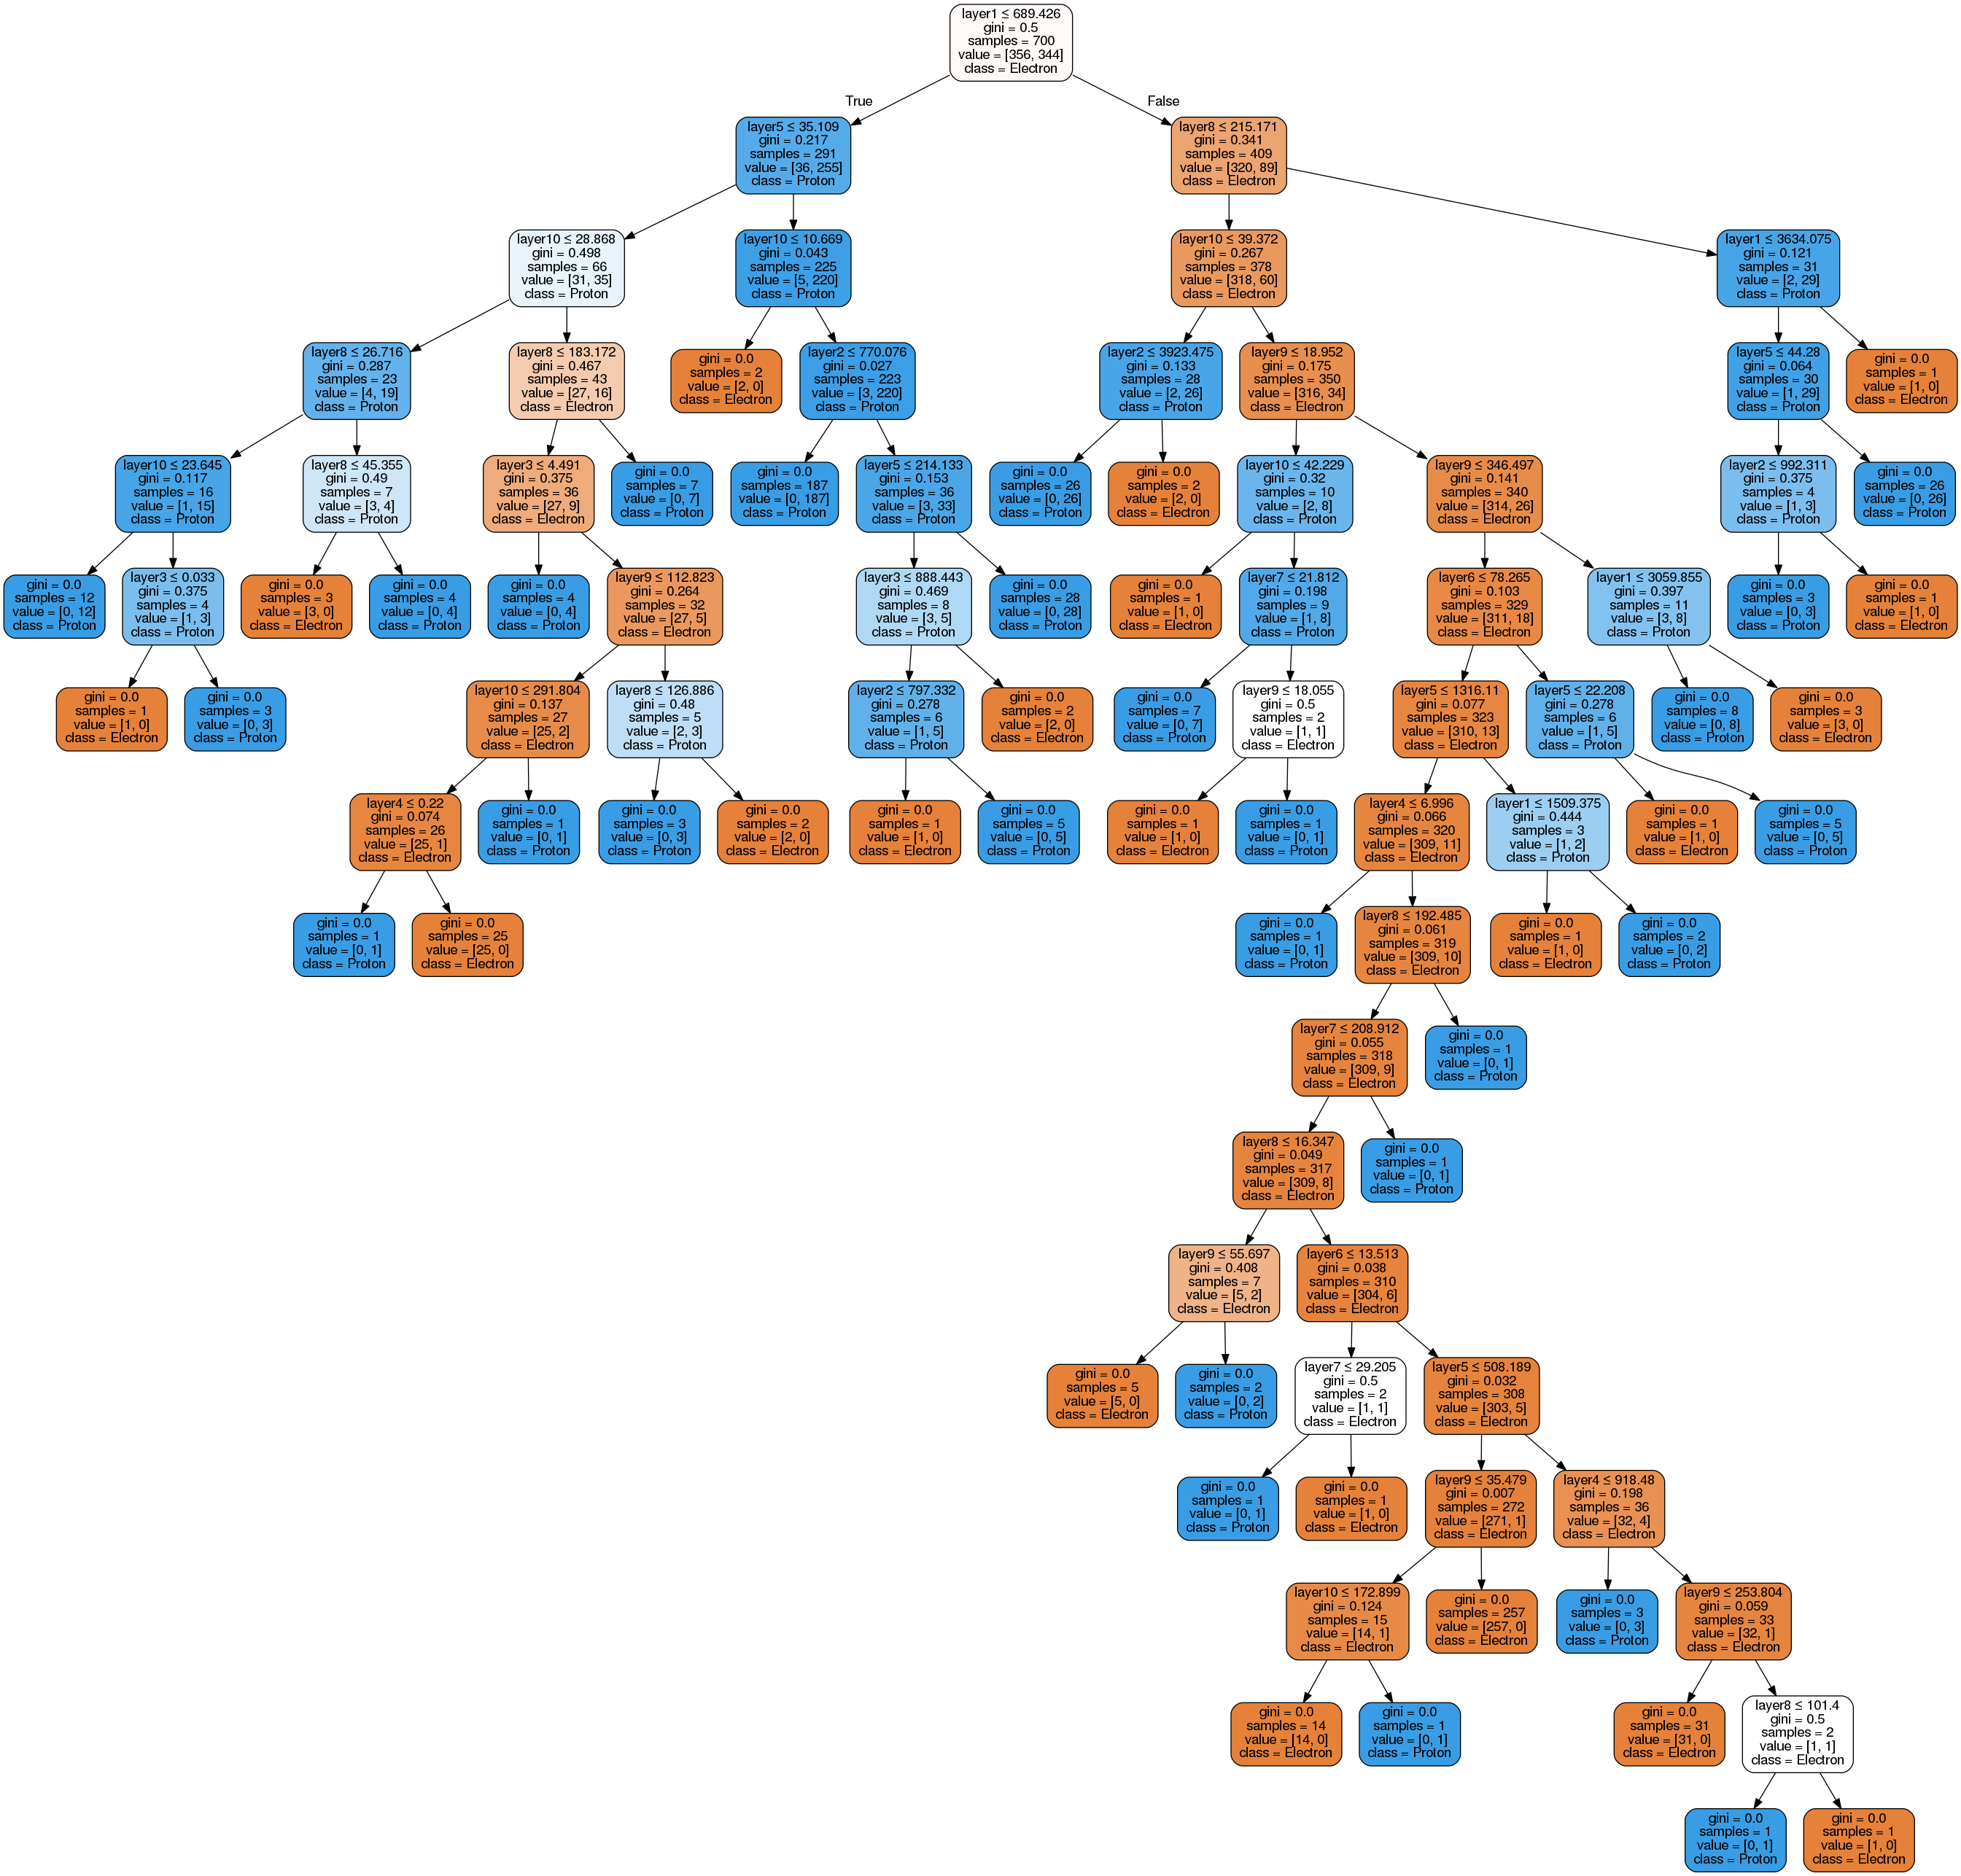

In [40]:
graph = dt_utils.plotDT(fit, data_names, target_names)
Image(graph.create_png())

In [41]:
d = model_selection.train_test_split(data_values, target_values, test_size=0.3, random_state=0)
expected, predicted = dt_utils.runML(tree.DecisionTreeClassifier(), d)
report = metrics.classification_report(expected, predicted)
print(report)

              precision    recall  f1-score   support

    Electron       0.90      0.88      0.89       144
      Proton       0.89      0.91      0.90       156

   micro avg       0.89      0.89      0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



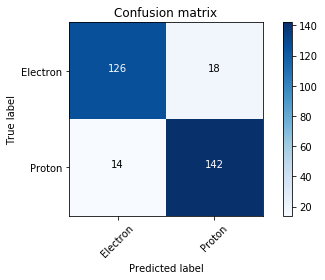

Accuracy: 0.8933333333333333


In [42]:
cm = metrics.confusion_matrix(expected, predicted)
dt_utils.plot_cm(cm, target_names)
plt.show()
acc = metrics.accuracy_score(expected, predicted)
print('Accuracy: '+str(acc))

In order to check how good this new detector is at distinguishing the two particles the new data is ran through the decision tree and an accuracy of 0.893 is observed, which is in the region of the initial detector.

The initial detector was good at detecting electron energies, however it was poor at detecting proton energies due to the stronger interactions between protons and matter. The initial detector was also good at distinguishing electrons from protons. Improvements were made to the detector by making the first layer thicker, allowing the proton to deposit more energy there, making it better at detecting the proton energies. That improoved the detection of proton energies, however made the electron detection worse. The new detector was still good at distinguishing the two particles from one another.

Even though this improvement makes sense in this simulation, it does not in a real life experiment. Because in a real experiment the first layer the particle hits has to be as thin as possible, so that interacts with the particle as little as possible, allowing more detections in the later stages of the detector. Therefore making the first layer thicker would defeat the purpose of having a second layer alltogether.